### CS784 - Final Project - Winter 2025

This notebook contains the source code for the CS 784 - Computational Linguistics course project.

It includes data processing, paper filteration, and basic quantitiative analysis.

Keyword: Grounding

##### Imports

In [ ]:
import datasets
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import umap
import numpy as np
import json
from tqdm import tqdm
import spacy
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
from itertools import combinations

nlp = spacy.load("en_core_web_sm")

In [ ]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatimasohail/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fatimasohail/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Load Dataset and Basic Preprocessing

In [ ]:
def load_dataset():
    dataset_ = datasets.load_dataset("Seed42Lab/AI-paper-crawl")
    return dataset_, list(dataset_.keys())

In [ ]:
def extract_sections(text):
    title_match = re.search(r'^(.*?)\s*abstract', text, re.IGNORECASE)
    abstract_match = re.search(r'abstract\s*(.*?)\s*introduction', text, re.IGNORECASE)
    content_match = re.search(r'introduction\s*(.*?)\s*references', text, re.IGNORECASE)
    ref_match = re.search(r'references\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1).strip() if title_match else ""
    abstract = abstract_match.group(1).strip() if abstract_match else ""
    content = content_match.group(1).strip() if content_match else ""
    refs = ref_match.group(1).strip() if ref_match else ""

    return title, abstract, content, refs

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return " ".join(tokens)

In [ ]:
def filter_papers(dataset, keys, keyword):
    filtered_papers = {key: [] for key in keys}

    for conf in keys:
        for i, paper in tqdm(enumerate(dataset[conf]), desc=f"Filtering {conf}"):
            content = paper.get("text", "")
            year = paper.get("year", "Unknown")

            # Filter by grounding
            if keyword in content.lower():
                filtered_papers[conf].append({"text": content, "year": year, "index": i})

    # Create a table with number of papers filtered for grounding
    table_data = []
    for conf in keys:
        filtered_count = len(filtered_papers[conf])
        table_data.append({"Conference": conf, "Num Papers": filtered_count})

    df = pd.DataFrame(table_data)
    print("\nNumber of Papers:")
    print(df.to_string(index=False))

    return filtered_papers

In [ ]:
def process_content(filtered_papers, keys):
    processed_papers = {key: [] for key in keys}
    for conf in keys:
        for i, paper in tqdm(enumerate(filtered_papers[conf]), desc=f"Text processing for {conf}"):
            content = paper.get("text", "")
            year = paper.get("year", "Unknown")
            title, abstract, main_content, ref = extract_sections(content)
            processed_papers[conf].append({"title": title, "abstract": abstract,
                                           "content": main_content,
                                           "year": year, "index": i})
    return processed_papers

In [ ]:
# Keyword frequency analysis
def keyword_frequency_analysis(filtered_papers, keywords):
    all_text = ""
    for conf in filtered_papers.keys():
        all_text_conf = ""
        for paper in filtered_papers[conf]:
            all_text_conf += paper.get("content")
        all_text += all_text_conf
    word_counts = Counter(all_text.split())
    keyword_counts = {kw: word_counts[kw] for kw in keywords if kw in word_counts}

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    plt.title("Keyword Frequency Analysis")
    plt.show()

    return keyword_counts

# Year of publication analysis
def year_publication_analysis(filtered_papers):
    years = []
    for conf in filtered_papers.keys():
        years_conf = []
        for paper in filtered_papers[conf]:
            years_conf.append(paper.get("year")[:4])
        years.extend(years_conf)
    year_counts = dict(sorted(Counter(years).items()))

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(year_counts.keys()), y=list(year_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.title("Year of Publication Analysis")
    plt.show()

    return year_counts

# Keyword frequency by year analysis
def keyword_frequency_by_year(filtered_papers, keywords):
    keyword_year_counts = {kw: Counter() for kw in keywords}
    for conf in filtered_papers.keys():
        for paper in filtered_papers[conf]:
            for kw in keywords:
                if kw in paper.get("content").lower():
                    keyword_year_counts[kw][paper.get("year")[:4]] += 1
    for kw in keywords:
        keyword_year_counts[kw] = dict(sorted(keyword_year_counts[kw].items()))

    # Plot
    for kw in keywords:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(keyword_year_counts[kw].keys()), y=list(keyword_year_counts[kw].values()))
        plt.xticks(rotation=90)
        plt.xlabel("Year")
        plt.ylabel("Frequency")
        plt.title(f"Keyword Frequency by Year - {kw}")
        plt.show()

    return keyword_year_counts

# Count of "grounding" in papers over time
def grounding_count_by_year(filtered_papers):
    grounding_counts = Counter()
    for conf in filtered_papers.keys():
        for paper in filtered_papers[conf]:
            grounding_counts[paper.get("year")[:4]] += paper.get("content").lower().count("grounding")

    grounding_counts = dict(sorted(grounding_counts.items()))

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(grounding_counts.keys()), y=list(grounding_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.title("Count of 'Grounding' in Papers Over Time")
    plt.show()

    return grounding_counts

# Distribution of count of "grounding" in papers
def grounding_count_distribution(filtered_papers):
    grounding_counts = Counter()
    for conf in filtered_papers.keys():
        for paper in filtered_papers[conf]:
            count = paper.get("content").lower().count("grounding")
            grounding_counts[count] += 1

    grounding_counts = dict(sorted(grounding_counts.items()))
    df = pd.DataFrame.from_dict(grounding_counts, orient='index').reset_index()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.displot(df, x='index', kind="kde")
    plt.xlabel("Count of 'Grounding'")
    plt.ylabel("Frequency")
    plt.title("Distribution of Count of 'Grounding' in Papers")
    plt.show()

    return grounding_counts

##### 1. Load dataset

In [ ]:
dataset, conf = load_dataset()

##### 2. Filter papers based on if they have 'grounding' in them

In [ ]:
filtered_papers = filter_papers(dataset, conf, 'grounding')

Filtering AAAI: 18849it [00:03, 4801.65it/s]
Filtering ACL: 8553it [00:02, 3609.41it/s]
Filtering CVPR: 12128it [00:03, 3808.99it/s]
Filtering ECCV: 6166it [00:01, 3697.09it/s]
Filtering EMNLP: 7109it [00:01, 3769.29it/s]
Filtering ICCV: 5369it [00:01, 3160.51it/s]
Filtering ICLR: 5806it [00:02, 2169.58it/s]
Filtering ICML: 10951it [00:04, 2495.57it/s]
Filtering IJCAI: 20284it [00:05, 3564.11it/s]
Filtering NAACL: 2994it [00:00, 3720.77it/s]
Filtering NIPS: 20284it [00:05, 3778.95it/s]


Number of Papers:
Conference  Num Papers
      AAAI         772
       ACL         632
      CVPR         862
      ECCV         511
     EMNLP         575
      ICCV         341
      ICLR         360
      ICML         360
     IJCAI         654
     NAACL         226
      NIPS         654


##### 3. Preprocessing

In [ ]:
process_papers = process_content(filtered_papers, conf)

Text processing for AAAI: 772it [00:00, 918.47it/s] 
Text processing for ACL: 632it [00:00, 910.18it/s]
Text processing for CVPR: 862it [00:01, 857.70it/s]
Text processing for ECCV: 511it [00:00, 788.56it/s]
Text processing for EMNLP: 575it [00:00, 953.99it/s] 
Text processing for ICCV: 341it [00:00, 826.37it/s]
Text processing for ICLR: 360it [00:00, 769.76it/s]
Text processing for ICML: 360it [00:00, 783.83it/s]
Text processing for IJCAI: 654it [00:00, 854.09it/s]
Text processing for NAACL: 226it [00:00, 1058.40it/s]
Text processing for NIPS: 654it [00:00, 890.12it/s] 


#### Basic EDA on all papers containing 'grounding'

##### 1. Frequency of related keywords

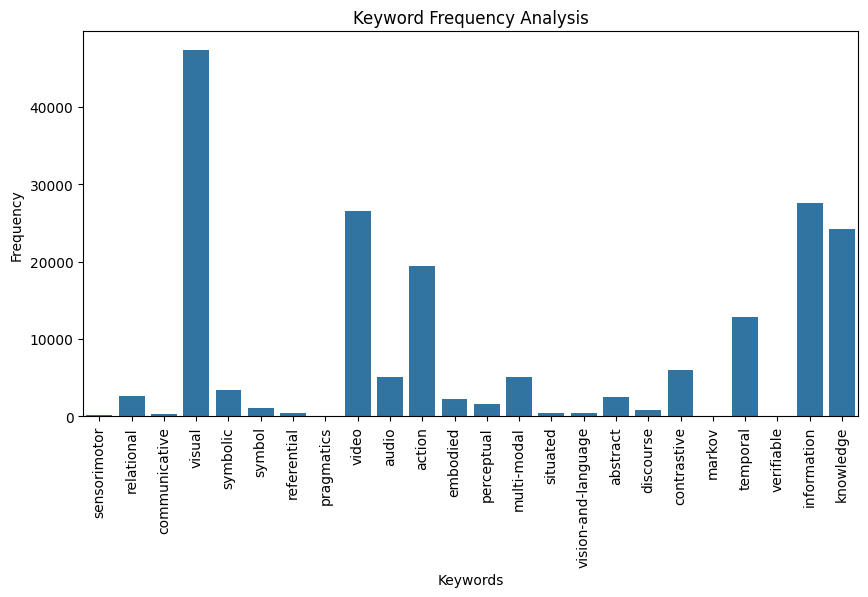

In [ ]:
keywords = ["sensorimotor", "relational", "communicative",
            "visual", "symbolic", "symbol", "referential", "pragmatics",
            "video", "audio", "action", "embodied", "perceptual",
            "multi-modal", "situated", "vision-and-language", "abstract",
            "discourse", "contrastive", "markov", "temporal", "verifiable",
            "information", "knowledge"]

keyword_counts = keyword_frequency_analysis(process_papers, keywords)

##### 2. Temporal trends for year of publication

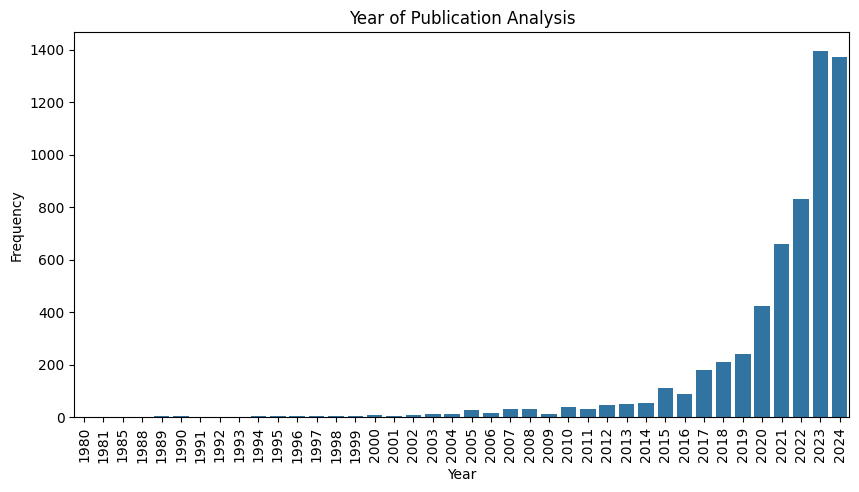

In [ ]:
year_counts = year_publication_analysis(process_papers)

##### 4. Temporal trends for year of publication by keyword

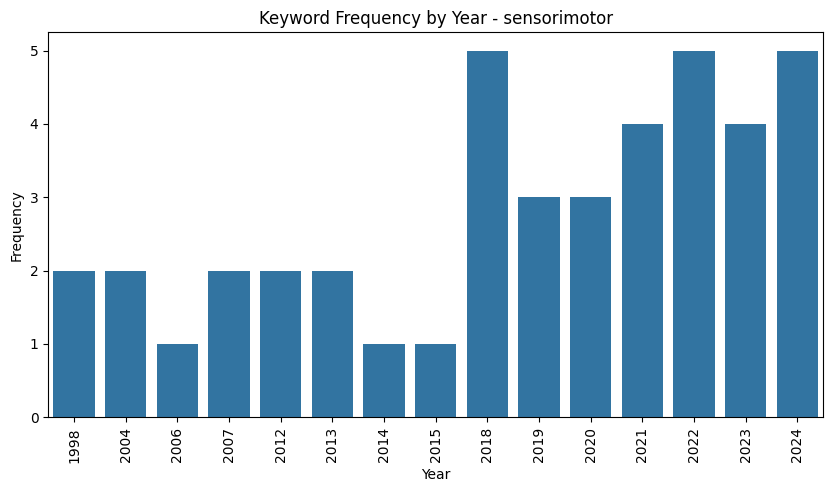

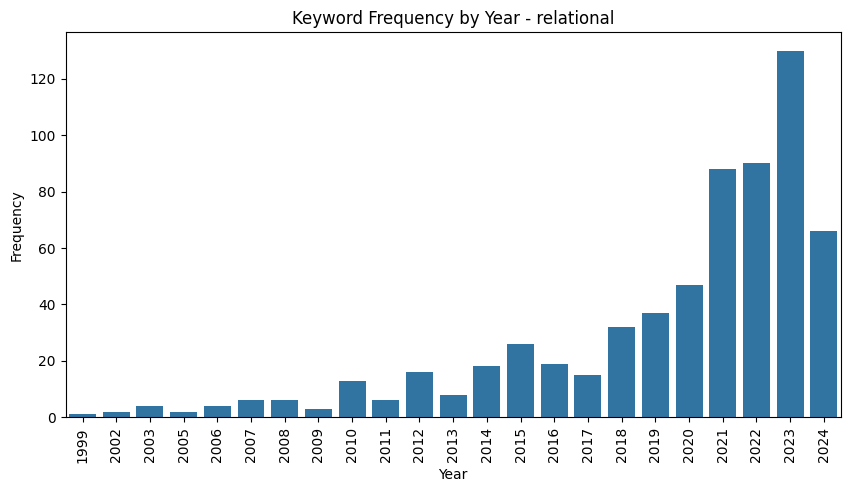

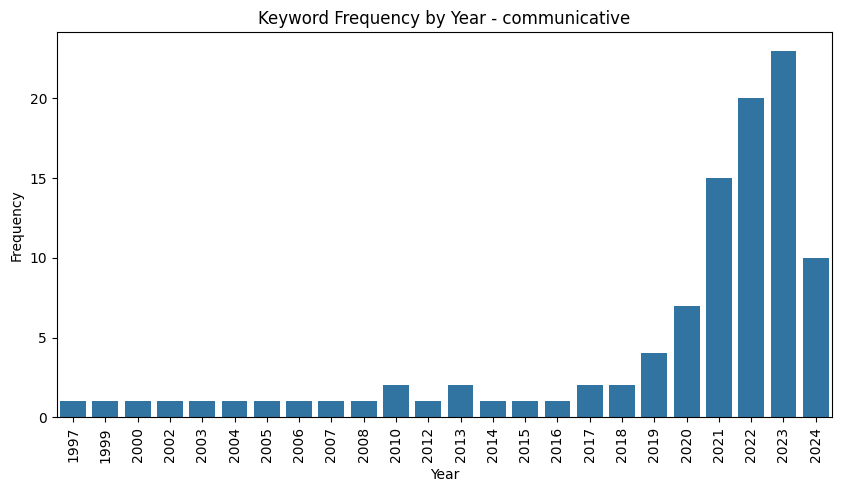

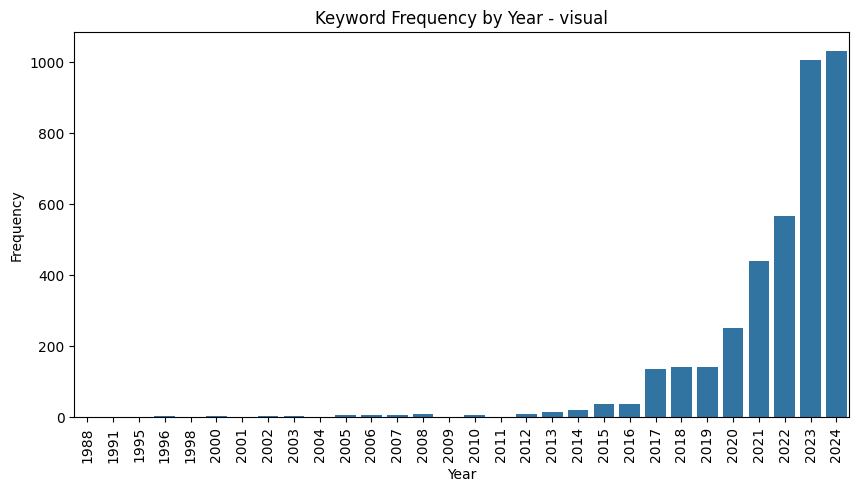

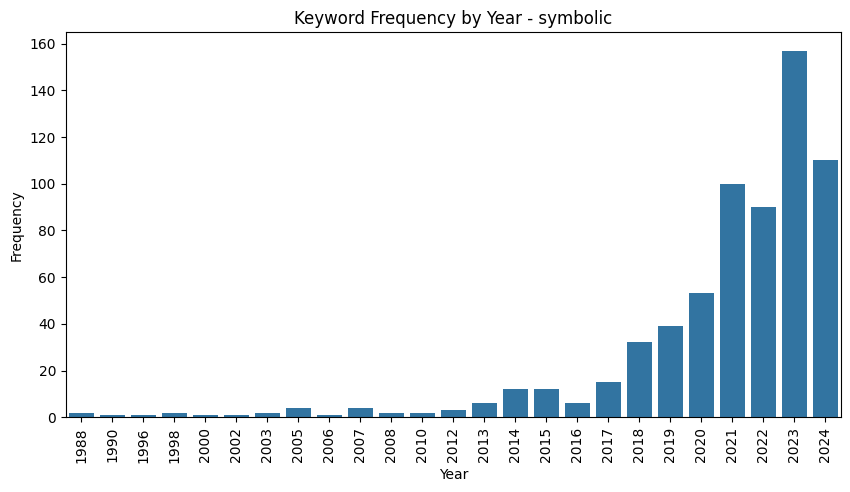

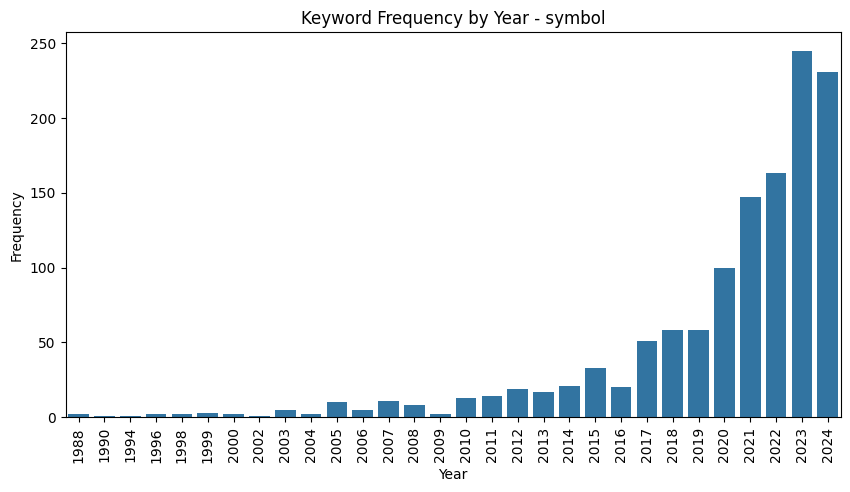

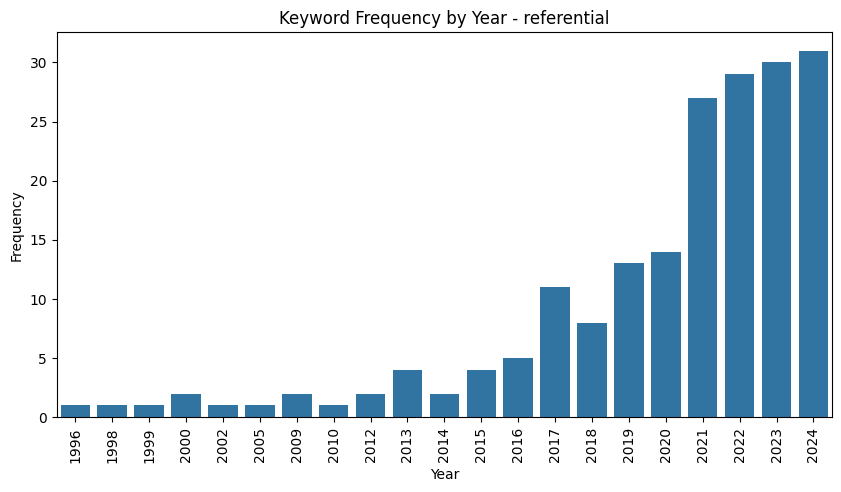

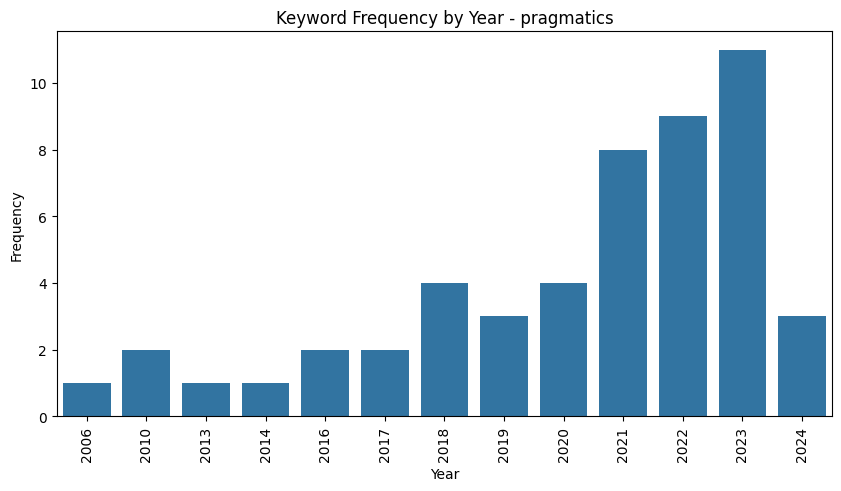

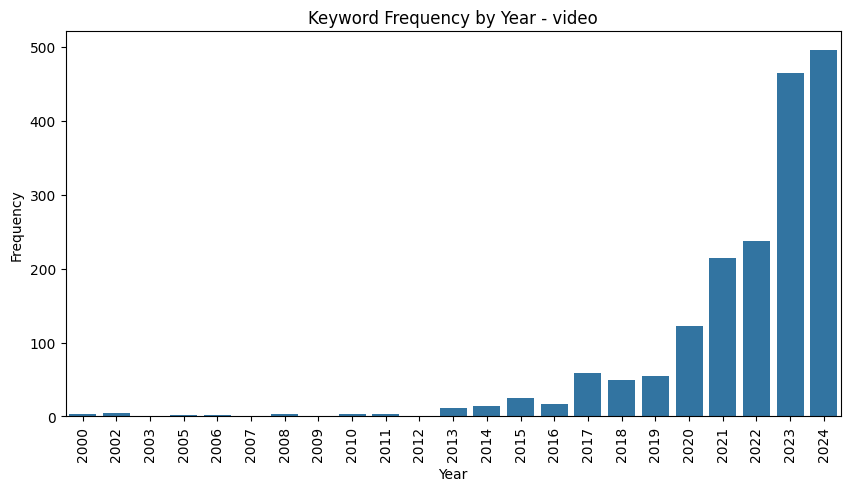

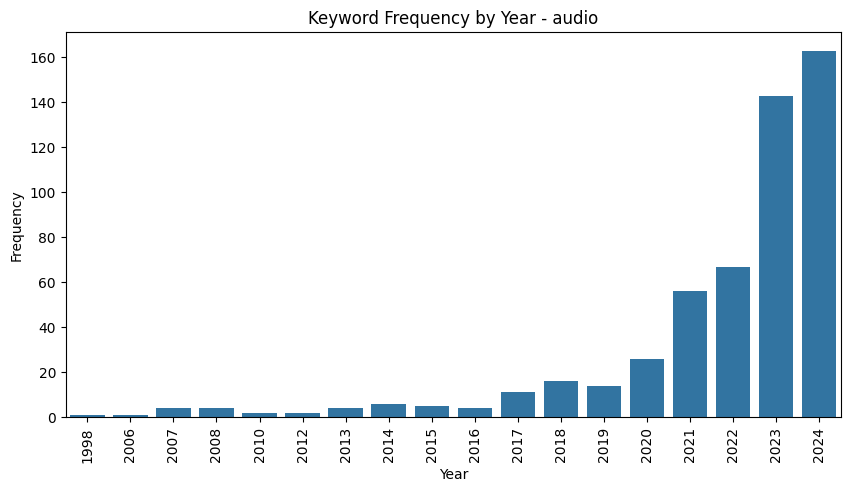

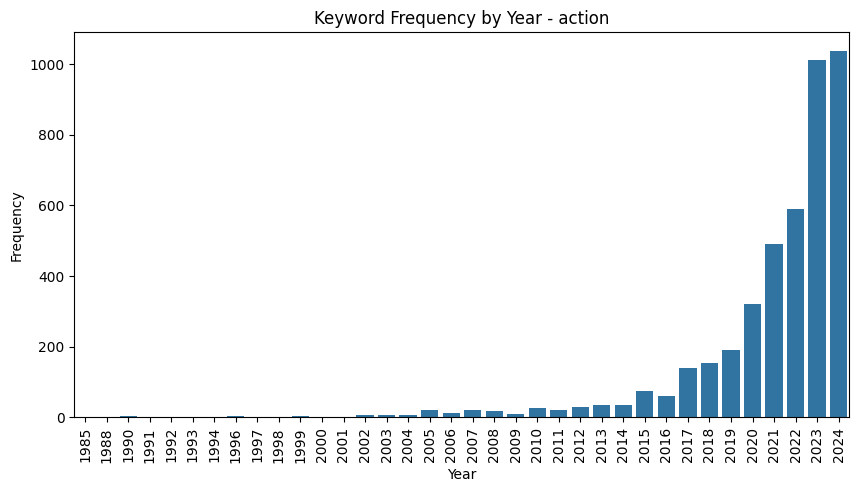

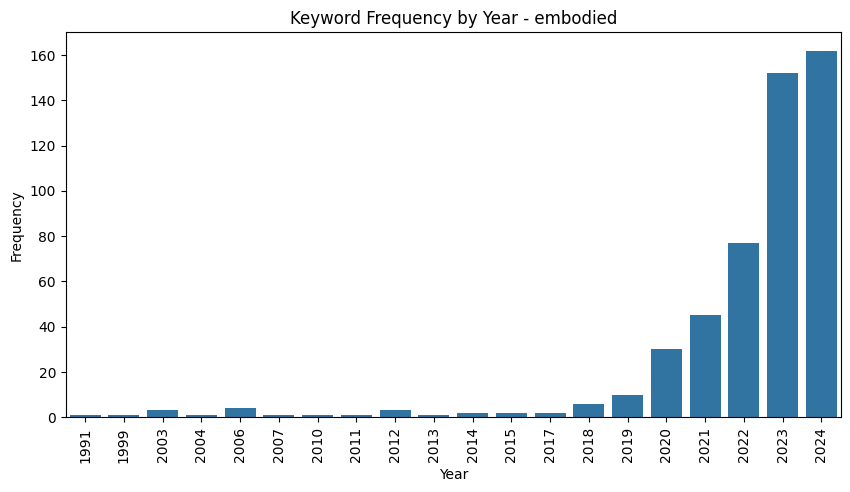

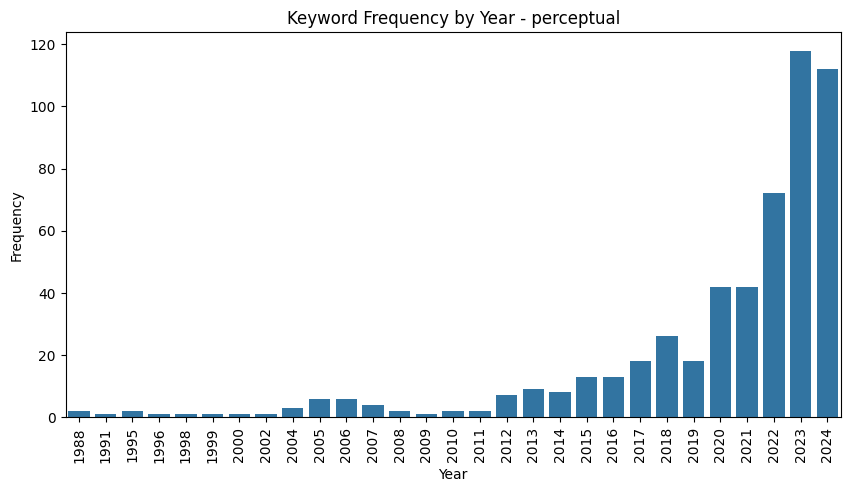

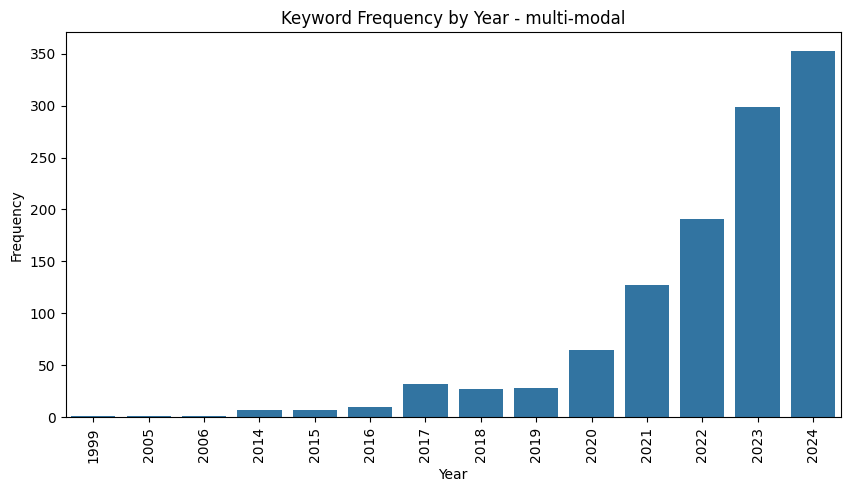

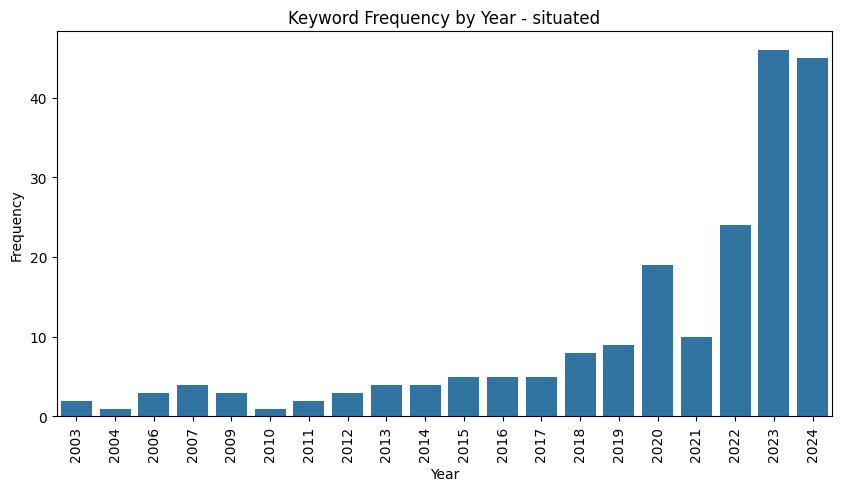

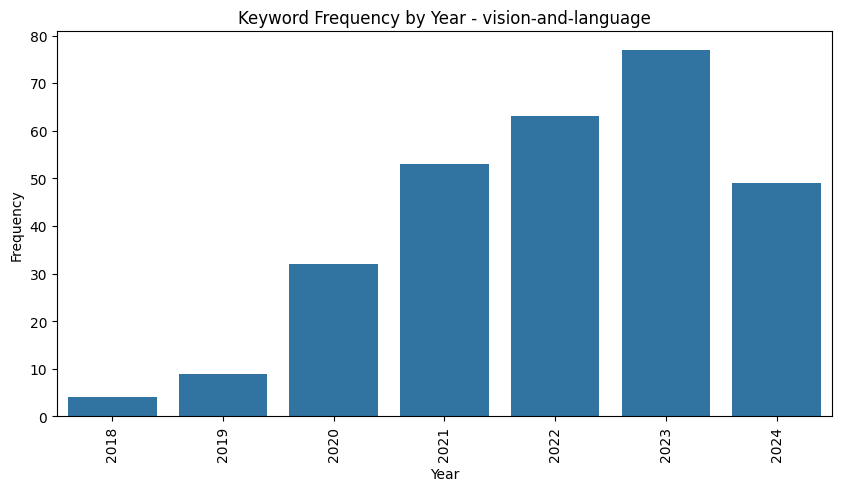

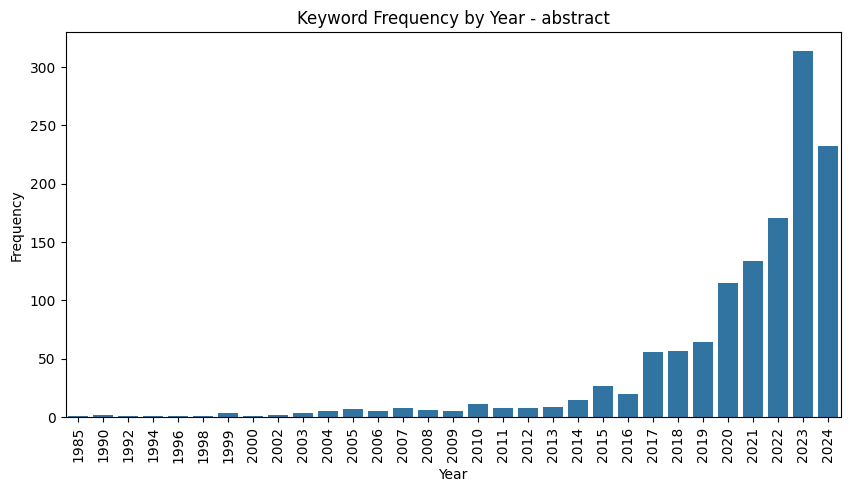

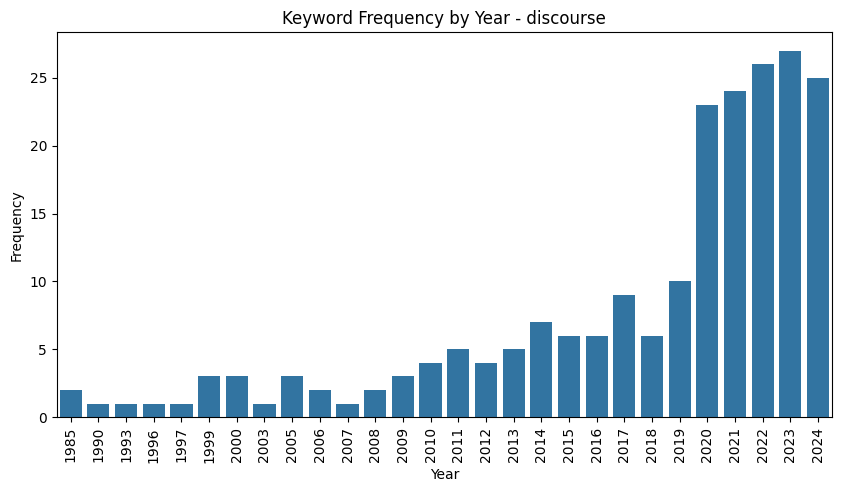

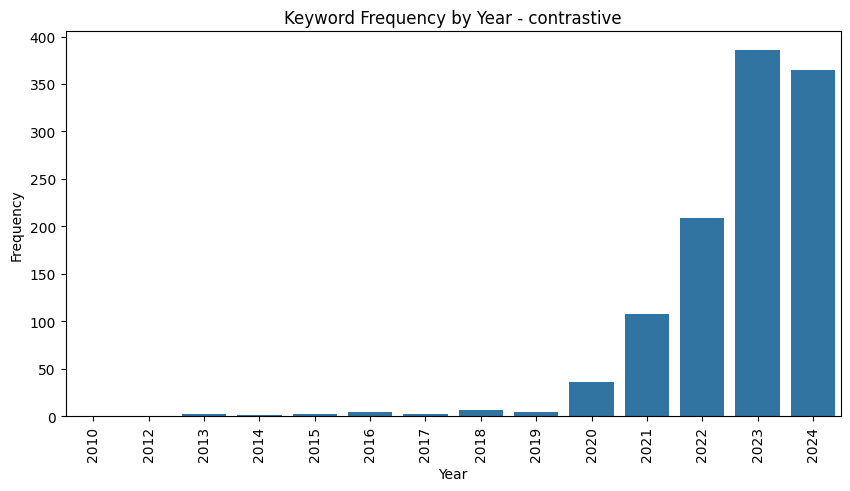

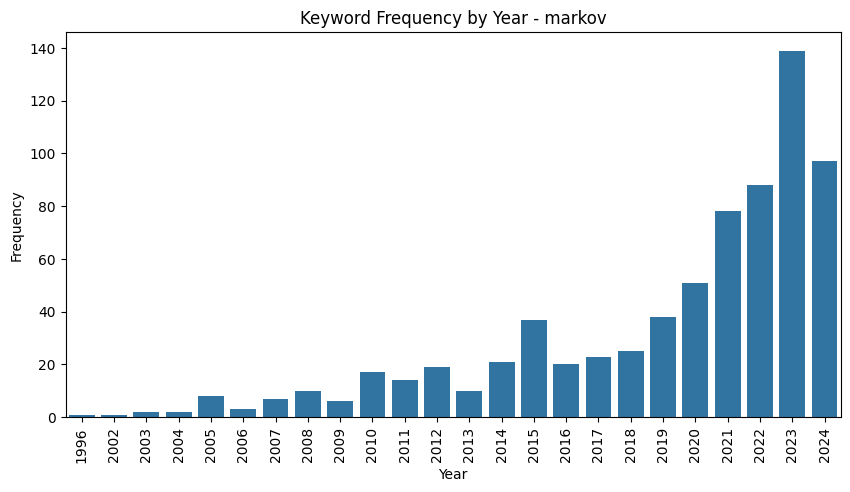

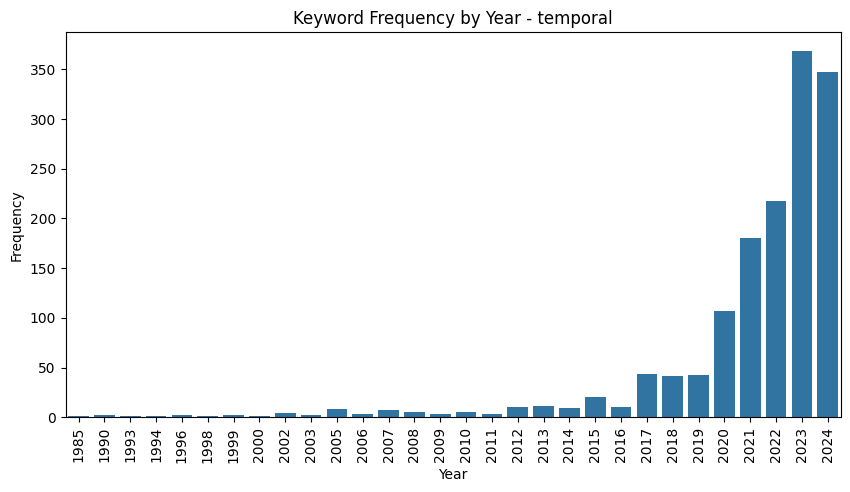

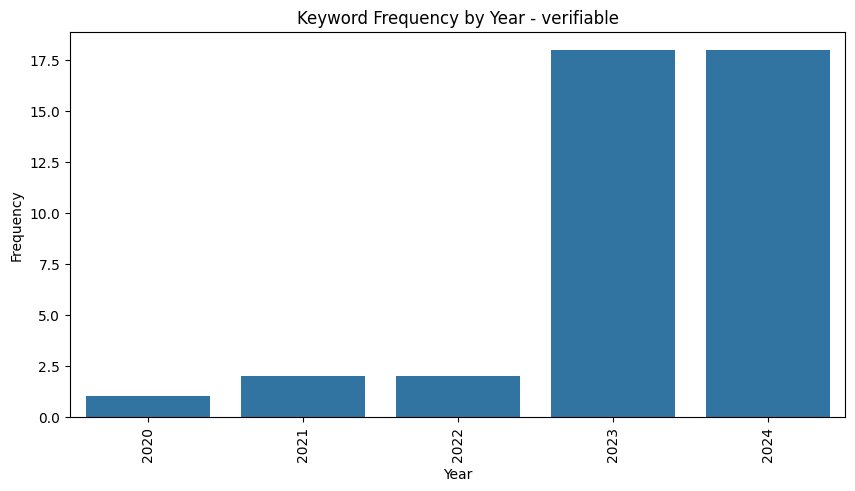

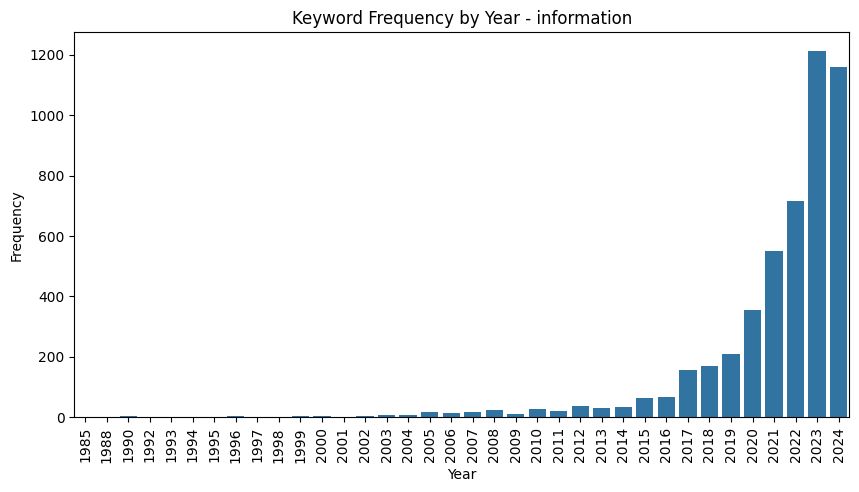

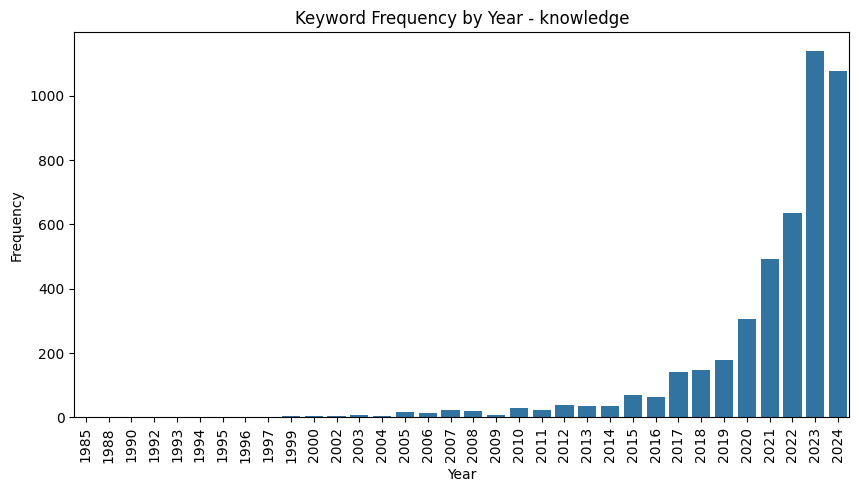

In [ ]:
keyword_year_counts = keyword_frequency_by_year(process_papers, keywords)

##### 5. Temporal trends of overall frequency of the term 'grounding' in papers

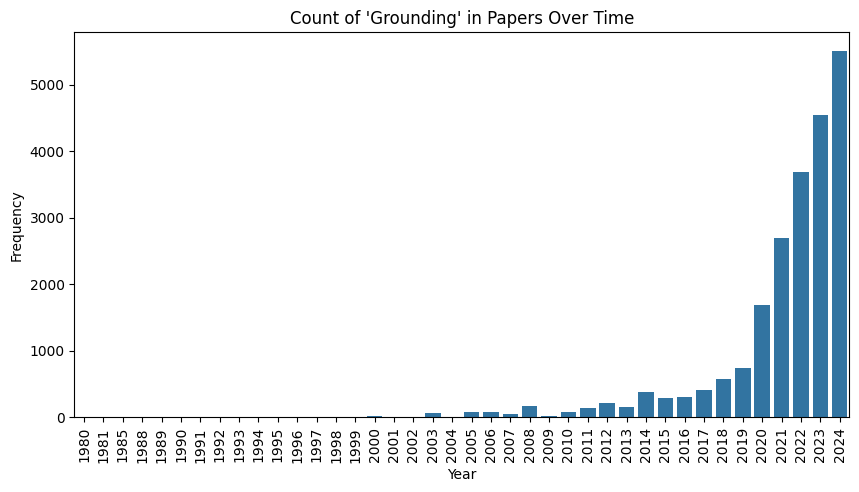

In [ ]:
count_by_year = grounding_count_by_year(process_papers)

##### 6. Count distribution of the term 'grounding' in papers

<Figure size 1000x500 with 0 Axes>

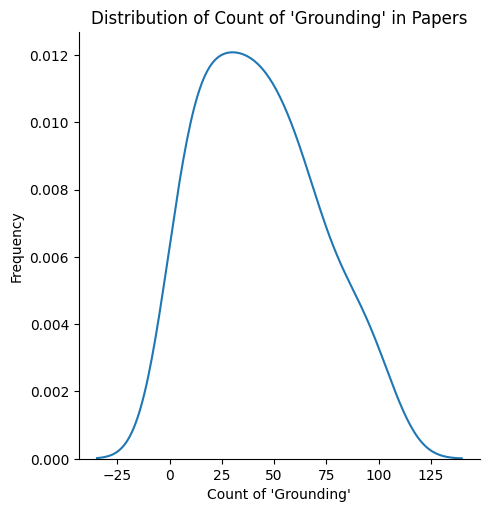

In [ ]:
grounding_dist = grounding_count_distribution(process_papers)

#### Filtering Papers to < 100 and Deeper Analysis

In [ ]:
def get_keyword_counts_filtered_papers(filtered_papers, keywords, confs):
    keyword_counts = {kw: 0 for kw in keywords}
    conf_counts = {conf: 0 for conf in confs} 
    for paper in filtered_papers:
        for kw in keywords:
            if kw in paper.get("content").lower():
                keyword_counts[kw] += 1
        conf_counts[paper.get('conf')] += 1

    table_data = []
    for keyword in keywords:
        filtered_count = keyword_counts[keyword]
        table_data.append({"Keyword": keyword, "Num Papers": filtered_count})

    print("\nPapers per Conf:")
    for conf in confs:
        print(f"{conf}: count={conf_counts[conf]}")

    df = pd.DataFrame(table_data)
    print("\nKeyword Frequency:")
    print(df.to_string(index=False))

    print("\nTop 7 Keywords:")
    for keyword in [keyword for keyword, count in Counter(keyword_counts).most_common(7)]:
        print(f"- {keyword}")
    return keyword_counts

In [ ]:
# Keyword frequency analysis
def keyword_analysis(filtered_papers, keywords):
    keyword_by_paper = {kw: 0 for kw in keywords}
    for paper in filtered_papers:
        for kw in keywords:
            if kw in paper.get("content").lower():
                keyword_by_paper[kw] += 1

    all_text = ""
    for paper in filtered_papers:
        all_text += paper.get("content")
    word_counts = Counter(all_text.split())
    keyword_counts = {kw: word_counts[kw] for kw in keywords if kw in word_counts}

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    plt.title("Keyword Frequency Analysis")
    plt.show()

    # plot by paper
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keyword_by_paper.keys()), y=list(keyword_by_paper.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    plt.title("Keyword Frequency by Paper")
    plt.show()

    return keyword_counts

# Keyword frequency by year analysis
def keyword_by_year(filtered_papers, keywords):
    years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

    keyword_year_counts = {kw: Counter() for kw in keywords}
    for sf in keywords:
        for year in years:
            keyword_year_counts[sf][year] = 0
            
    for paper in filtered_papers:
        for kw in keywords:
            if kw in paper.get("content").lower():
                keyword_year_counts[kw][paper.get("year")[:4]] += 1
    for kw in keywords:
        keyword_year_counts[kw] = dict(sorted(keyword_year_counts[kw].items()))

    # Plot
    plt.figure(figsize=(15, 8))
    for kw in keywords:
        plt.plot(list(keyword_year_counts[kw].keys()), 
                 list(keyword_year_counts[kw].values()), 
                 label=kw)
    plt.xticks(rotation=90)
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.title("Keyword Frequency by Year")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Keywords")
    plt.tight_layout()
    plt.show()

    return keyword_year_counts

In [ ]:
# TF-IDF Paper Search
def search_papers(filtered_papers, query, num=10):
    corpus = [paper.get('content') for paper in filtered_papers]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    query_vec = vectorizer.transform([query])
    scores = (tfidf_matrix * query_vec.T).toarray().flatten()
    ranked_papers = sorted(zip(scores, filtered_papers), key=lambda x: x[0], reverse=True)
    return ranked_papers[:num]  # Return top num papers

# Co-occurrence Matrix
def build_cooccurrence_matrix(filtered_papers, keywords):
    word_pairs = Counter()
    for paper in filtered_papers:
        words = paper['content'].split()
        for word1, word2 in combinations(set(words) & set(keywords), 2):
            word_pairs[(word1, word2)] += 1
    # Print matrix of keyword co-occurrences
    # print("Co-occurrence Matrix:")
    # matrix = []
    # for word1 in keywords:
    #     row = []
    #     for word2 in keywords:
    #         row.append(word_pairs[(word1, word2)])
    #     print(f"{word1}: {row}\n")
    #     matrix.append(row)
    return word_pairs

# BERT-based Clustering
def cluster_papers(filtered_papers, n_clusters=5):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode([paper['content'] for paper in filtered_papers], convert_to_tensor=True)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings.cpu().numpy())
    clusters = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(labels):
        clusters[label].append(filtered_papers[idx]['title'])
    return clusters

# Temporal Analysis
def analyze_temporal_trends(filtered_papers):
    year_counts = Counter()
    for paper in filtered_papers:
        year_counts[paper['year'][:4]] += 1

    year_counts = dict(sorted(year_counts.items()))

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=list(year_counts.keys()), y=list(year_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel("Year")
    plt.ylabel("Number of Papers")
    plt.show()

    return sorted(year_counts.items())

# Subfield Correlation
def subfield_correlation(filtered_papers, subfields):
    subfield_counts = {sf: 0 for sf in subfields}
    for paper in filtered_papers:
        for sf in subfields:
            if sf in paper['content']:
                subfield_counts[sf] += 1
    return subfield_counts

# Topic Modeling with LDA
def topic_modeling(filtered_papers, num_topics=5):
    vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    X = vectorizer.fit_transform([paper.get("abstract") for paper in filtered_papers])
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    words = vectorizer.get_feature_names_out()
    topics = {i: [words[idx] for idx in topic.argsort()[-10:][::-1]] for i, topic in enumerate(lda.components_)}

    # Print topics
    for topic, words in topics.items():
        print(f"Topic {topic}: {', '.join(words)}")

    return topics

In [ ]:
popular_keywords = ["sensorimotor", "relational", "communicative",
                    "visual", "symbolic", "symbol", "referential",
                    "video", "audio", "action", "embodied", "perceptual",
                    "multi-modal", "situated", "vision-and-language", "contrastive",
                    "markov", "temporal"]

In [ ]:
confs = filtered_papers.keys()
papers_dataset = {key: [] for key in confs}
for conf in confs:
    for i, paper in enumerate(process_papers[conf]):
        year = paper.get("year", "Unknown")
        title, abstract, main_content = paper.get("title", ""), paper.get("abstract", ""), paper.get("content", "")
        papers_dataset[conf].append({"title": title, "abstract": abstract,
                                     "content": main_content, "conf": conf,
                                     "year": year, "index": i})

for conf in filtered_papers.keys():
    for paper in filtered_papers[conf]:
        paper.update({'conf':conf})

# TF-IDF Search
dataset_papers = [paper for conf in process_papers.keys() for paper in papers_dataset[conf]]
results = search_papers(dataset_papers, "grounding", 100)
print("Top 100 relevant papers for 'grounding':")
search_results = []
for score, paper in results:
    print(f"{paper['title'][:40]} ({paper['year']}) - Score: {score:.4f}")
    search_results.append(paper)

# Save results as dataframe and csv
df = pd.DataFrame(search_results)
df.to_csv("grounding_search_results.csv", index=False)


Top 100 relevant papers for 'grounding':
Proceedings of the 2024 Conference of th (2024) - Score: 0.3111
LLaVA-Grounding: Grounded Visual Chat wi (2024) - Score: 0.2337
Comprehensive Visual Grounding for Video (2024) - Score: 0.2156
Joint Visual Grounding and Tracking with (2023) - Score: 0.1911
The Thirty-Fourth AAAI Conference on Art (2020) - Score: 0.1799
Learning to Generate Grounded Visual   C (2020) - Score: 0.1786
VideoGrounding-DINO: Towards Open-Vocabu (2024) - Score: 0.1742
Proceedings of the 2024 Conference of th (2024) - Score: 0.1734
ScanReason: Empowering 3D Visual Groundi (2024) - Score: 0.1654
GLIGEN: Open-Set Grounded Text-to-Image  (2023) - Score: 0.1635
Cycle-Consistency Learning for Captionin (2024) - Score: 0.1604
What, when, and where? Self-Supervised S (2024) - Score: 0.1519
Refer-it-in-RGBD: A Bottom-up Approach f (2021) - Score: 0.1499
Multi3DRefer: Grounding Text Description (2023) - Score: 0.1476
Can I Trust Your Answer? Visually Ground (2024) - Score: 0.1453

In [ ]:
# paper dict to json
with open('grounding_search_results.json', 'w') as f:
    json.dump(search_results, f)

In [ ]:
# Keyword Counts and Conf Distribution
keyword_counts_filtered = get_keyword_counts_filtered_papers(search_results, popular_keywords, confs)


Papers per Conf:
AAAI: count=11
ACL: count=9
CVPR: count=31
ECCV: count=18
EMNLP: count=2
ICCV: count=10
ICLR: count=3
ICML: count=3
IJCAI: count=5
NAACL: count=4
NIPS: count=4

Keyword Frequency:
            Keyword  Num Papers
       sensorimotor           2
         relational           8
      communicative           1
             visual          88
           symbolic           5
             symbol          15
        referential          11
              video          43
              audio          11
             action          78
           embodied           8
         perceptual           9
        multi-modal          36
           situated           4
vision-and-language           5
        contrastive          30
             markov           4
           temporal          31

Top 7 Keywords:
- visual
- action
- video
- multi-modal
- temporal
- contrastive
- symbol


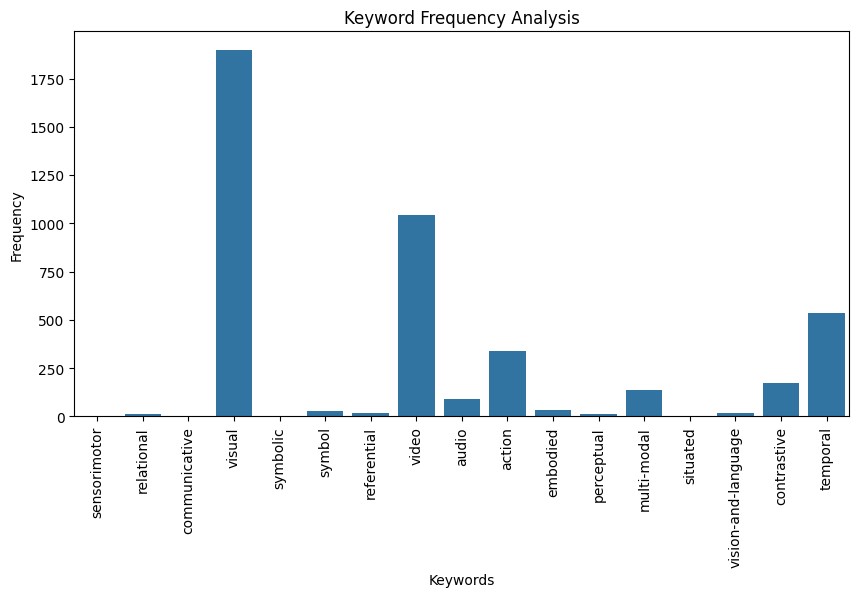

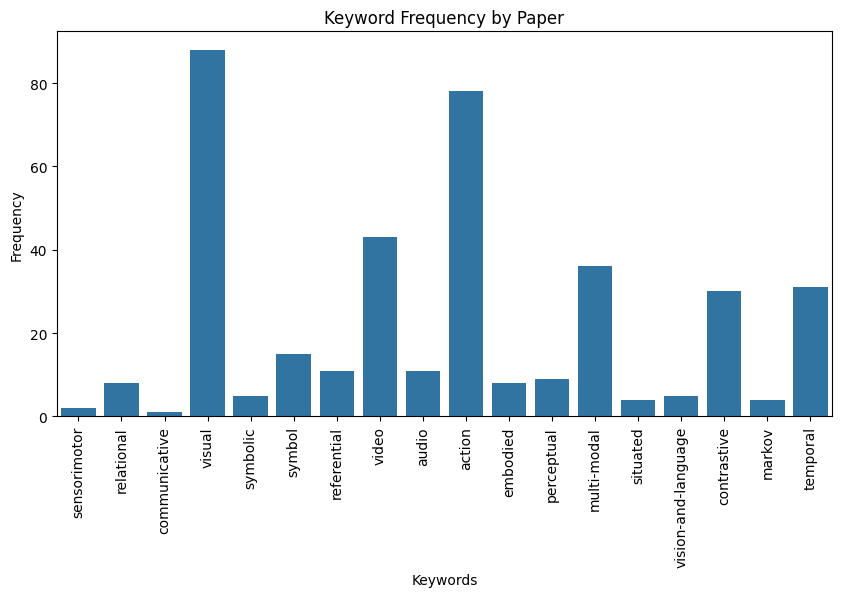

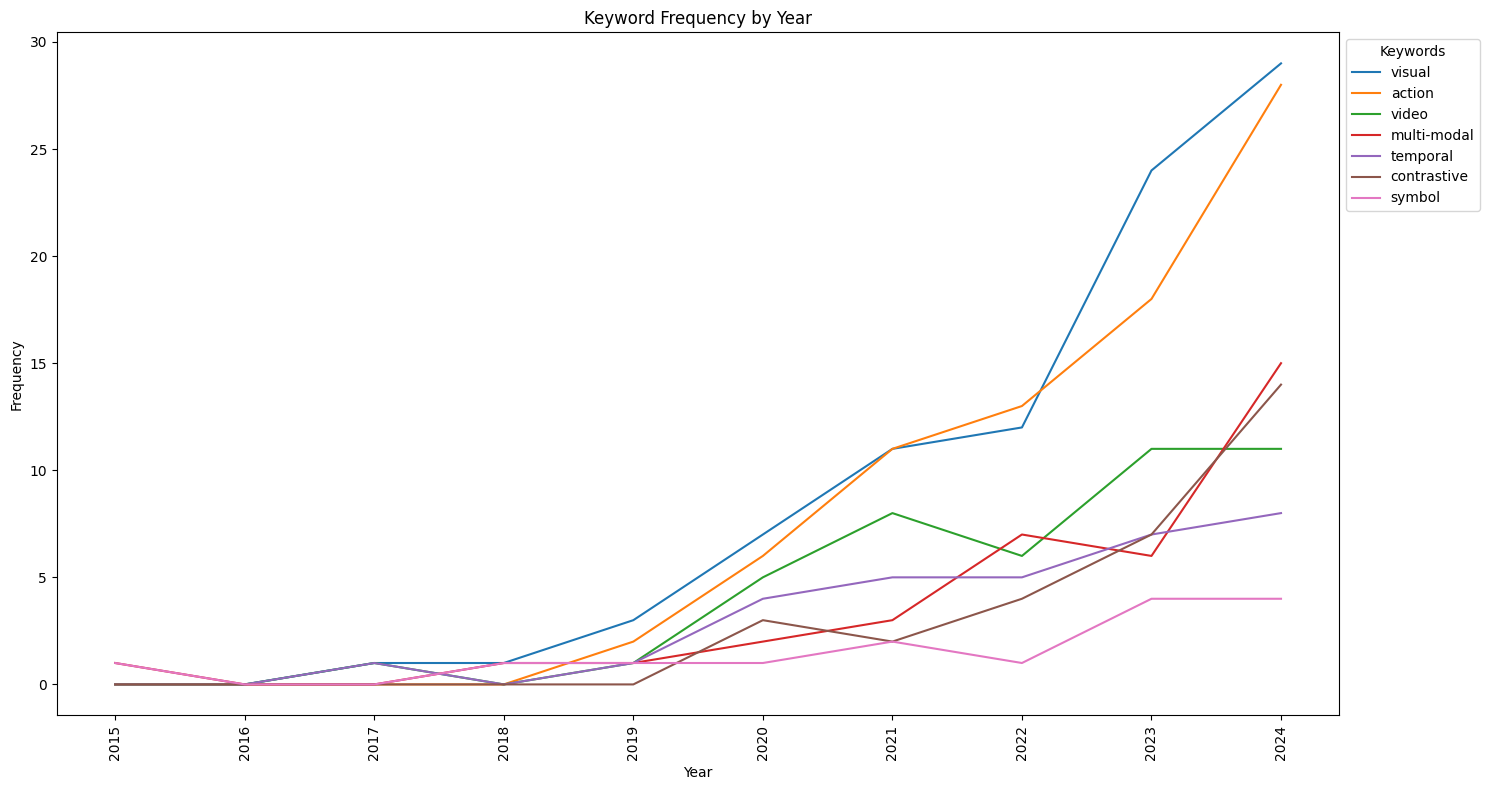

{'visual': {'2015': 0,
  '2016': 0,
  '2017': 1,
  '2018': 1,
  '2019': 3,
  '2020': 7,
  '2021': 11,
  '2022': 12,
  '2023': 24,
  '2024': 29},
 'action': {'2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 2,
  '2020': 6,
  '2021': 11,
  '2022': 13,
  '2023': 18,
  '2024': 28},
 'video': {'2015': 0,
  '2016': 0,
  '2017': 1,
  '2018': 0,
  '2019': 1,
  '2020': 5,
  '2021': 8,
  '2022': 6,
  '2023': 11,
  '2024': 11},
 'multi-modal': {'2015': 1,
  '2016': 0,
  '2017': 0,
  '2018': 1,
  '2019': 1,
  '2020': 2,
  '2021': 3,
  '2022': 7,
  '2023': 6,
  '2024': 15},
 'temporal': {'2015': 0,
  '2016': 0,
  '2017': 1,
  '2018': 0,
  '2019': 1,
  '2020': 4,
  '2021': 5,
  '2022': 5,
  '2023': 7,
  '2024': 8},
 'contrastive': {'2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 0,
  '2020': 3,
  '2021': 2,
  '2022': 4,
  '2023': 7,
  '2024': 14},
 'symbol': {'2015': 1,
  '2016': 0,
  '2017': 0,
  '2018': 1,
  '2019': 1,
  '2020': 1,
  '2021': 2,
  '2022': 1,
  '2023': 4,
  '2

In [ ]:
top_7 = []
for keyword in [keyword for keyword, count in Counter(keyword_counts_filtered).most_common(7)]:
    top_7.append(keyword)

# Keyword Analysis
keyword_counts = keyword_analysis(search_results, popular_keywords)
keyword_by_year(search_results, top_7)


In [ ]:
popular_keywords.append("grounding")
# Co-occurrence Matrix 
word_pairs = build_cooccurrence_matrix(search_results, popular_keywords)
print("Co-occurrence Matrix:")
word_pairs.most_common(10)

Co-occurrence Matrix:


[(('visual', 'grounding'), 85),
 (('video', 'grounding'), 34),
 (('visual', 'multi-modal'), 31),
 (('multi-modal', 'grounding'), 31),
 (('action', 'grounding'), 30),
 (('temporal', 'grounding'), 29),
 (('contrastive', 'grounding'), 29),
 (('video', 'temporal'), 27),
 (('video', 'visual'), 27),
 (('temporal', 'visual'), 27)]

In [ ]:
word_pairs

Counter({('visual', 'grounding'): 85,
         ('video', 'grounding'): 34,
         ('visual', 'multi-modal'): 31,
         ('multi-modal', 'grounding'): 31,
         ('action', 'grounding'): 30,
         ('temporal', 'grounding'): 29,
         ('contrastive', 'grounding'): 29,
         ('video', 'temporal'): 27,
         ('video', 'visual'): 27,
         ('temporal', 'visual'): 27,
         ('visual', 'action'): 27,
         ('visual', 'contrastive'): 18,
         ('temporal', 'action'): 16,
         ('video', 'action'): 15,
         ('video', 'multi-modal'): 12,
         ('temporal', 'multi-modal'): 12,
         ('video', 'contrastive'): 11,
         ('temporal', 'contrastive'): 11,
         ('multi-modal', 'contrastive'): 11,
         ('referential', 'grounding'): 10,
         ('contrastive', 'visual'): 10,
         ('perceptual', 'grounding'): 9,
         ('visual', 'referential'): 8,
         ('embodied', 'grounding'): 8,
         ('action', 'contrastive'): 7,
         ('relationa

In [ ]:
# BERT Clustering
clusters = cluster_papers(search_results, n_clusters=5)
print("Document Clusters:")
for cluster, papers in clusters.items():
    print(f"\nCluster {cluster}:\n")
    for paper in papers[:5]:
        print(f"- {paper}\n")

Document Clusters:

Cluster 0:

- ScanReason: Empowering 3D Visual Grounding   with Reasoning Capabilities   Chenming Zhu1,2, Tai Wang2, Wenwei Zhang2, Kai Chen2, and Xihui Liu1†   1 The University of Hong Kong   2 Shanghai AI Laboratory   chaimzhu@connect.hku.hk   https://zcmax.github.io/projects/ScanReason

- Refer-it-in-RGBD: A Bottom-up Approach for   3D Visual Grounding in RGBD Images   Haolin Liu1,2   Anran Lin1   Xiaoguang Han1,2,*   Lei Yang4   Yizhou Yu3,4   Shuguang Cui1,2   1SRIBD, CUHK-Shenzhen†   2FNii, CUHK-Shenzhen‡   3Deepwise AI Lab   4The University of Hong Kong

- Cyclic Co-Learning of Sounding Object Visual Grounding and Sound Separation   Yapeng Tian1, Di Hu2,3∗, Chenliang Xu1∗   1University of Rochester, 2 Gaoling School of Artiﬁcial Intelligence, Renmin University of China   3 Beijing Key Laboratory of Big Data Management and Analysis Methods   {yapengtian,chenliang.xu}@rochester.edu, dihu@ruc.edu.cn

- Unveiling Parts Beyond Objects:   Towards Finer-Granularity 

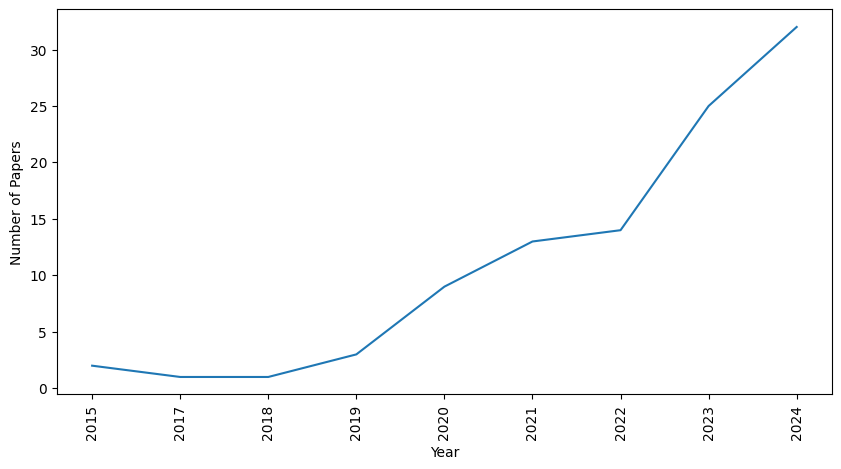

Temporal Trends:
[('2015', 2), ('2017', 1), ('2018', 1), ('2019', 3), ('2020', 9), ('2021', 13), ('2022', 14), ('2023', 25), ('2024', 32)]


In [ ]:
# Temporal Trends
temporal_trends = analyze_temporal_trends(search_results)
print("Temporal Trends:")
print(temporal_trends)

In [ ]:
# Subfield Correlation
subfields = ["robotics", "natural language processing", "computer vision", "reinforcement learning", 
             "explainable AI", "XAI", "multimodal", "cognitive", "language interpretation", 
             "language generation", "dialogue systems","human-robot interaction", "deep learning",
             "healthcare", "medical imaging", "autonomous vehicles", "affective computing",
             "emotion recognition", "speech reconition", "speech synthesis", "audio generation", 
             "video generation", "image generation", "image recognition", "image classification",
             "image segmentation", "object detection", "object recognition", "object tracking"]
correlations = subfield_correlation(search_results, subfields)
print("Subfield Correlations:")
correlations

Subfield Correlations:


{'robotics': 8,
 'natural language processing': 13,
 'computer vision': 18,
 'reinforcement learning': 9,
 'explainable AI': 0,
 'XAI': 0,
 'multimodal': 40,
 'cognitive': 10,
 'language interpretation': 1,
 'language generation': 5,
 'dialogue systems': 5,
 'human-robot interaction': 4,
 'deep learning': 6,
 'healthcare': 1,
 'medical imaging': 0,
 'autonomous vehicles': 0,
 'affective computing': 0,
 'emotion recognition': 0,
 'speech reconition': 0,
 'speech synthesis': 0,
 'audio generation': 0,
 'video generation': 0,
 'image generation': 6,
 'image recognition': 2,
 'image classification': 2,
 'image segmentation': 2,
 'object detection': 37,
 'object recognition': 5,
 'object tracking': 2}

In [ ]:
dict(sorted(correlations.items(), key=lambda x: x[1], reverse=True))

{'multimodal': 40,
 'object detection': 37,
 'computer vision': 18,
 'natural language processing': 13,
 'cognitive': 10,
 'reinforcement learning': 9,
 'robotics': 8,
 'deep learning': 6,
 'image generation': 6,
 'language generation': 5,
 'dialogue systems': 5,
 'object recognition': 5,
 'human-robot interaction': 4,
 'image recognition': 2,
 'image classification': 2,
 'image segmentation': 2,
 'object tracking': 2,
 'language interpretation': 1,
 'healthcare': 1,
 'explainable AI': 0,
 'XAI': 0,
 'medical imaging': 0,
 'autonomous vehicles': 0,
 'affective computing': 0,
 'emotion recognition': 0,
 'speech reconition': 0,
 'speech synthesis': 0,
 'audio generation': 0,
 'video generation': 0}

In [ ]:
# Topic Modeling
topics = topic_modeling(search_results, num_topics=3)

Topic 0: recent, problems, according, answers, improved, non, finally, impressive, investigate, identify
Topic 1: visual, video, language, model, task, models, dataset, tasks, image, 3d
Topic 2: recent, problems, answers, according, improved, non, impressive, finally, linguistic, investigate


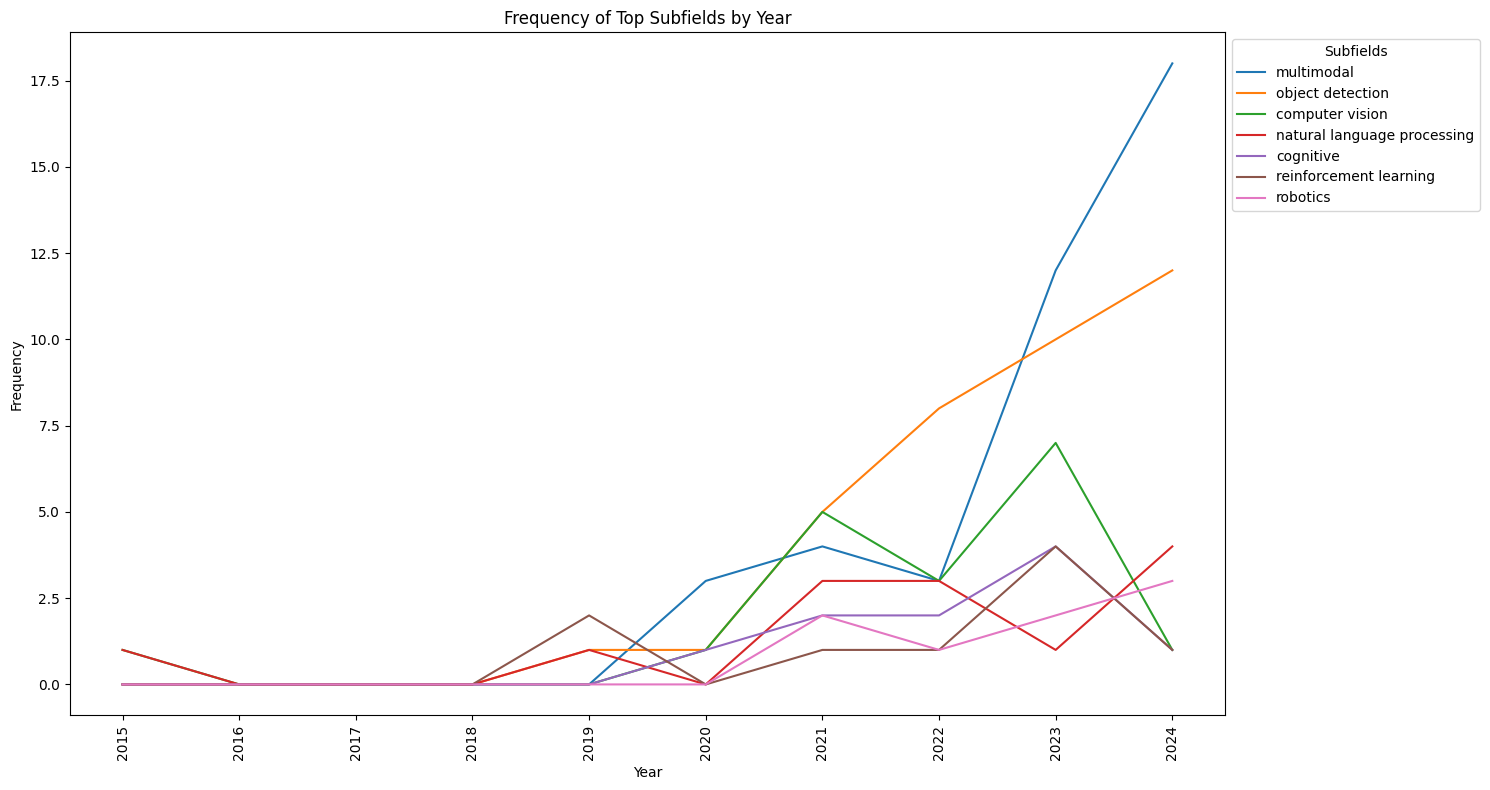

In [ ]:
# top 7 subfields by year
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

def top_subfields_by_year(filtered_papers, subfields):
    subfield_counts = {sf: Counter( ) for sf in subfields}
    for sf in subfields:
        for year in years:
            subfield_counts[sf][year] = 0
    for paper in filtered_papers:
        for sf in subfields:
            if sf in paper['content']:
                subfield_counts[sf][paper['year'][:4]] += 1
    for sf in subfields:
        subfield_counts[sf] = dict(sorted(subfield_counts[sf].items()))
    return subfield_counts

subfield_counts_by_year = top_subfields_by_year(search_results, subfields)

# Plot top subfields by year in a single plot
plt.figure(figsize=(15, 8))
for sf in subfields:
    if sum(subfield_counts_by_year[sf].values()) < 5:  # Skip subfields with low counts
        continue
    plt.plot(list(subfield_counts_by_year[sf].keys()), 
             list(subfield_counts_by_year[sf].values()), 
             label=sf)

plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Frequency of Top Subfields by Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Subfields")
plt.tight_layout()
plt.show()